# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler

# Load the Datasets
We load all the required datasets.
For columns that represent dates (e.g., date), we use parse_dates=["date"] when reading the files to automatically convert them into datetime64 objects. This makes time-based operations much easier more convenient for time series analysis.

In [2]:
train = pd.read_csv("train.csv", parse_dates=["date"])
test = pd.read_csv("test.csv", parse_dates=["date"])
stores = pd.read_csv("stores.csv")
transactions = pd.read_csv("transactions.csv", parse_dates=["date"])
holidays = pd.read_csv("holidays_events.csv", parse_dates=["date"])
oil = pd.read_csv("oil.csv", parse_dates=["date"])

In [3]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [4]:
test.columns

Index(['id', 'date', 'store_nbr', 'family', 'onpromotion'], dtype='object')

In [5]:
stores.columns

Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')

In [6]:
transactions.columns

Index(['date', 'store_nbr', 'transactions'], dtype='object')

In [7]:
holidays.columns

Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')

In [8]:
oil.columns

Index(['date', 'dcoilwtico'], dtype='object')

# Merge Auxiliary Data into Train

- **stores.csv** → Adds store information (city, state, type, cluster).

- **transactions.csv** → Adds daily transactions per store.

- **oil.csv** → Adds oil prices (missing values forward-filled).

- **holidays_events.csv** → Adds holiday/event type for each date.

In [9]:
train = train.merge(stores, on="store_nbr", how="left")
train = train.merge(transactions, on=["date", "store_nbr"], how="left")
oil["dcoilwtico"] = oil["dcoilwtico"].fillna(method="ffill")
train = train.merge(oil, on="date", how="left")
train = train.merge(holidays[["date","type"]], on="date", how="left")
train.head()

C:\Users\Amr\AppData\Local\Temp\ipykernel_31716\1955500918.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil["dcoilwtico"] = oil["dcoilwtico"].fillna(method="ffill")


,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,type_y
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday


In [10]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,type_y
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday


### Renaming Columns for Clarity

- After merging multiple datasets, some columns inherited generic names like `type_x` and `type_y`.  
- To make the dataset more interpretable, we renamed them:

    - **type_x** (coming from stores.csv) →  **store_type**

        Indicates the type of store (A, B, C, or D).

    - **type_y** (coming from holidays_events.csv) → **day_type**

        Classifies each date as either a special event (Holiday, Transfer, Additional, Event, etc.) or a regular Work Day (for dates without special events).

In [11]:
train = train.rename(columns={
    'type_x': 'store_type',
    'type_y': 'day_type'
})

## Drop ID Column

In [12]:
train.drop("id",axis=1,inplace=True)

# Merge Auxiliary Data into Test

- **stores.csv** → Adds store-level information (`city`, `state`, `type`, `cluster`).  

- **transactions.csv** → Adds the number of daily transactions for each store (based on `date` + `store_nbr`).  

- **oil.csv** → Adds oil price (`dcoilwtico`) for each date.  

- **holidays_events.csv** → Adds holiday/event type (`type`) for each date.  

**Note**: Unlike the train dataset, the test dataset does not include the `sales` column, because `sales` is the target variable we aim to predict. All other auxiliary data is merged to provide the necessary context for forecasting.  


In [13]:
test = test.merge(stores, on="store_nbr", how="left")
test = test.merge(transactions, on=["date", "store_nbr"], how="left")
test = test.merge(oil, on="date", how="left")
test = test.merge(holidays[["date","type"]], on="date", how="left")
test.head()

,id,date,store_nbr,family,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,type_y
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NaN,46.8,NaN
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,NaN,46.8,NaN
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,NaN,46.8,NaN
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,NaN,46.8,NaN
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,NaN,46.8,NaN


### Renaming Columns for Clarity (Test Set)

- Similar to the train dataset, merging multiple files created generic column names (`type_x`, `type_y`).  
- To make the test dataset more interpretable, we renamed them:

    - **type_x** (from `stores.csv`) → **store_type**  
      Indicates the type of store (A, B, C, or D).  

    - **type_y** (from `holidays_events.csv`) → **day_type**  
      Classifies each date as either a special event (Holiday, Transfer, Additional, Event, etc.) or a regular Work Day (for dates without special events).  


In [14]:
test = test.rename(columns={
    'type_x': 'store_type',
    'type_y': 'day_type'
})

# **Dataset Overview**

## Shape of the dataset

In [15]:
train.shape

(3054348, 12)

In [16]:
train.head()

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,dcoilwtico,day_type
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday


## Dataset info (data types + missing values)

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 12 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   store_nbr     int64         
 2   family        object        
 3   sales         float64       
 4   onpromotion   int64         
 5   city          object        
 6   state         object        
 7   store_type    object        
 8   cluster       int64         
 9   transactions  float64       
 10  dcoilwtico    float64       
 11  day_type      object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(5)
memory usage: 279.6+ MB


## Missing values count

In [18]:
train.isnull().sum()

date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
store_type            0
cluster               0
transactions     249117
dcoilwtico       880308
day_type        2551824
dtype: int64

**Columns with Missing Values**  
   - **`transactions` → 249,117 missing (~8.2%)**  
     - Not all stores have transaction logs available.  
     - Missing values can be imputed using median per store or interpolation.  

   - **`dcoilwtico` → 880,308 missing (~28.8%)**  
     - Oil prices are not recorded on weekends and holidays (markets closed).  
     - We can fix it using forward-fill (`ffill`) or interpolation.  

   - **`day_type` → 2,551,824 missing (~83.5%)**  
     - Represents holiday/event types.  
     - Missing values simply mean “regular work day.”  
     - Can safely replace NaN with `"Work Day"`.  

#### Key Takeaways
- Core dataset is very clean (no missing values in essential features like `sales`, `date`, `store_nbr`).  
- Missing values are expected in auxiliary features (transactions, oil prices, holidays).  

In [19]:
test.isna().sum()

id                  0
date                0
store_nbr           0
family              0
onpromotion         0
city                0
state               0
store_type          0
cluster             0
transactions    28512
dcoilwtico       7128
day_type        26730
dtype: int64

## **Columns with Missing Values — Test Dataset**

- **`transactions` → 28,512 missing (100%)**  
  - All transaction values are missing in the test set.  
  - Since this feature is not available for prediction, we will drop the `transactions` column from both **train** and **test** to keep the datasets aligned.  

- **`dcoilwtico` → 7,128 missing (~2.4%)**  
  - Oil prices are not recorded on weekends and holidays (markets closed).  
  - We can handle missing values using **forward-fill (`ffill`)**.  

- **`day_type` → 26,730 missing (~9.0%)**  
  - Represents holiday/event types.  
  - Missing values simply mean “regular work day.”  
  - We can safely replace NaN with `"Work Day"`.  


## Check duplicates

In [20]:
train.duplicated().sum()

np.int64(30294)

In [21]:
test.duplicated().sum()

np.int64(0)

In [22]:
initial_rows = train.shape[0]
train = train.drop_duplicates()
print(f"Removed {initial_rows - train.shape[0]} duplicate rows.")
train.shape

Removed 30294 duplicate rows.


(3024054, 12)

**We removed all duplicate rows to ensure data consistency:**  

## Data Validation & Cleaning Checks

## Handle missing values
- Logical imputation strategies:  
  - `transactions`: median per store.  
  - `dcoilwtico`: forward-fill.  
  - `day_type`: fill NaN with `"Work Day"`.  

**Fill missing values of dcoilwtico column with forward-fill then back-fill for any leading NaNs**

In [23]:
train['dcoilwtico'] = train['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

C:\Users\Amr\AppData\Local\Temp\ipykernel_31716\1575899407.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train['dcoilwtico'] = train['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')


**Fill missing values day_type column with "Work Day"**

In [24]:
train['day_type'] = train['day_type'].fillna('Work Day')

In [25]:
train.isnull().sum()


date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
store_type           0
cluster              0
transactions    247170
dcoilwtico           0
day_type             0
dtype: int64

**Fill missing values of dcoilwtico column in the test dataset with forward-fill then back-fill for any leading NaNs**

In [26]:
test['dcoilwtico'] = test['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

C:\Users\Amr\AppData\Local\Temp\ipykernel_31716\706933418.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test['dcoilwtico'] = test['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')


**Fill missing values day_type column in the test dataset with "Work Day"**

In [27]:
test['day_type'] = test['day_type'].fillna('Work Day')

## **Dropping the `transactions` Column**

To keep the datasets consistent, we drop `transactions` from both **train** and **test**:

In [28]:
train.drop("transactions",axis=1,inplace=True)

In [29]:
test.drop("transactions",axis=1,inplace=True)

## Check Hidden Duplicated

In [30]:
dup = train.drop("day_type",axis=1).duplicated()
dup_index = dup[dup].index
train = train.drop(dup_index)

In [31]:
train.shape

(3000888, 11)

## **Address data inconsistencies**

## Check data types

In [32]:
train.dtypes

date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
city                   object
state                  object
store_type             object
cluster                 int64
dcoilwtico            float64
day_type               object
dtype: object

- **Categorical Columns:** family, city, state, store_type, day_type.  
- **Numeric Columns:** id, store_nbr, sales, onpromotion, cluster, transactions, dcoilwtico.  
- **Datetime Columns:** date.


## List of all columns

In [33]:
train.columns

Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state',
       'store_type', 'cluster', 'dcoilwtico', 'day_type'],
      dtype='object')

## Unique values exploration

**View all distinct product families available in the dataset.**

In [34]:
train.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

**Get unique store types in the dataset**

In [35]:
train.store_type.unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

**Get unique day types in the dataset**

In [36]:
train.day_type.unique()

array(['Holiday', 'Work Day', 'Additional', 'Transfer', 'Event', 'Bridge'],
      dtype=object)

## Count unique values in each column

In [37]:
train.nunique()

date             1684
store_nbr          54
family             33
sales          379610
onpromotion       362
city               22
state              16
store_type          5
cluster            17
dcoilwtico        994
day_type            6
dtype: int64

## Store Network Structure
- **54 stores** across **22 cities** and **16 states**
- Average of ~2.45 stores per city
- **17 clusters** for geographic or performance grouping
- **5 store types** (A, B, C, D, E) indicating different formats or tiers

## Temporal Coverage
- **1,684 days** of data ≈ **4.6 years** of daily records
- **6 day types** (including Work Day, Holiday, Work Day, Additional, Event, Transfer, Bridge)

## Product & Sales Diversity
- **33 product families** offering diverse category analysis
- **379,610 unique sales values** showing high variability
- **362 promotion levels** indicating varied promotional intensity
- **4,993 transaction count variations** suggesting different store sizes

## Data Quality Indicators
- **3M+ records** with unique IDs - comprehensive dataset
- **994 oil price points** - good external economic indicator coverage

## Descriptive statistics for all columns

In [38]:
train.describe(include='all')

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,day_type
count,3000888,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3000888,3000888,3000888,3.000888e+06,3.000888e+06,3000888
unique,NaN,NaN,33,NaN,NaN,22,16,5,NaN,NaN,6
top,NaN,NaN,AUTOMOTIVE,NaN,NaN,Quito,Pichincha,D,NaN,NaN,Work Day
freq,NaN,NaN,90936,NaN,NaN,1000296,1055868,1000296,NaN,NaN,2558952
mean,2015-04-24 08:27:04.703088384,2.750000e+01,NaN,3.577757e+02,2.602770e+00,NaN,NaN,NaN,8.481481e+00,6.792490e+01,NaN
min,2013-01-01 00:00:00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,1.000000e+00,2.619000e+01,NaN
25%,2014-02-26 18:00:00,1.400000e+01,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,4.000000e+00,4.637750e+01,NaN
50%,2015-04-24 12:00:00,2.750000e+01,NaN,1.100000e+01,0.000000e+00,NaN,NaN,NaN,8.500000e+00,5.341000e+01,NaN
75%,2016-06-19 06:00:00,4.100000e+01,NaN,1.958473e+02,0.000000e+00,NaN,NaN,NaN,1.300000e+01,9.572000e+01,NaN
max,2017-08-15 00:00:00,5.400000e+01,NaN,1.247170e+05,7.410000e+02,NaN,NaN,NaN,1.700000e+01,1.106200e+02,NaN


# Dataset Statistical Summary

### Date
- **Range**: 2013-01-01 → 2017-08-15  
- **Median**: April 26, 2015 → balanced 4.6-year coverage  
- **Temporal spread**: Evenly distributed across the period

### Store Number
- **Range**: Store 1 → Store 54  
- **Mean**: 27.5 → stores evenly distributed numerically  
- **Std**: 15.6 → good spread across store IDs

### Product Family
- **33 unique categories**  
- **Most frequent**: **Automotive** (91,638 entries)  
- Dominant category suggests focus on automotive products

### Sales
- **Range**: $0 → $124,717
  
- **Median**: $11  →  highly right-skewed distribution

  
- **Mean**:  $358.78 (vs Median $11) → extreme outliers present

  
- **Std**: $1,106.76 → very high variability

### On Promotion
- **Range**: 0 → 741 items  
- **Mean**: 2.61 items promoted  
- **75% records**: 0 promotions → sparse promotional activity  
- **Std**: 12.26 → high variation in promotion intensity

### Geography
- **22 cities** → **Top: Quito** (1,008,018 entries)  
- **16 states** → **Top: Pichincha** (1,064,019 entries)  
- Geographic concentration in specific areas

### Store Type
- **5 store types** → **Most frequent: Type D** (1,008,018 entries)  
- Type D dominates the network

### Cluster
- **17 clusters** → Range: 1-17  
- **Mean**: 8.48 → balanced cluster distribution  
- **Std**: 4.65 → moderate variation in cluster sizes

### Transactions
- **Range**: 5 → 8,359 transactions  
- **Median**: 1,395 → right-skewed distribution  
- **Mean**: 1,673 → larger stores pull average up  
- **Std**: 930.65 → significant store size variation

### Oil Price (dcoilwtico)
- **Range**: $26.19 → $110.62  
- **Median**: $53.41 (vs Mean $67.86) → left-skewed distribution  
- **Std**: $25.66 → high volatility in oil prices

### Day Type
- **6 unique day types**  
- **Most frequent**: **Work Day** (2,560,734 entries)  
- Balanced representation of different day types

# Check Outliers

In [39]:
num_cols=train.select_dtypes(include=["int64","float64"])
for i,col in enumerate(num_cols):
    Q1=train[col].quantile(0.25)
    Q3=train[col].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    outliers=train[col][(train[col]<lower_bound) | (train[col]>upper_bound)]
    print(f"{i+1}: {col} - {len(outliers)}")

1: store_nbr - 0
2: sales - 447105
3: onpromotion - 611329
4: cluster - 0
5: dcoilwtico - 0


<Axes: title={'center': 'sales before log'}, xlabel='sales', ylabel='Count'>

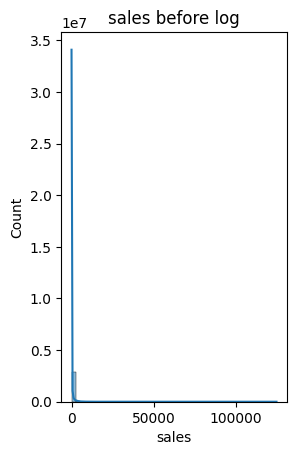

In [40]:
plt.subplot(1,2,2)
plt.title("sales before log")
sns.histplot(train["sales"], bins=50, kde=True)

<Axes: title={'center': 'sales before log'}, ylabel='sales'>

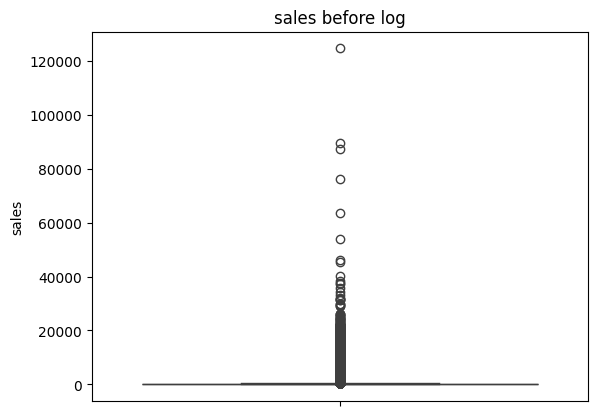

In [41]:
plt.title("sales before log")
sns.boxplot(train["sales"])

## Handling sales outliers

In [42]:
train["sales"]=np.log1p(train["sales"])

<Axes: title={'center': 'sales After log'}, ylabel='sales'>

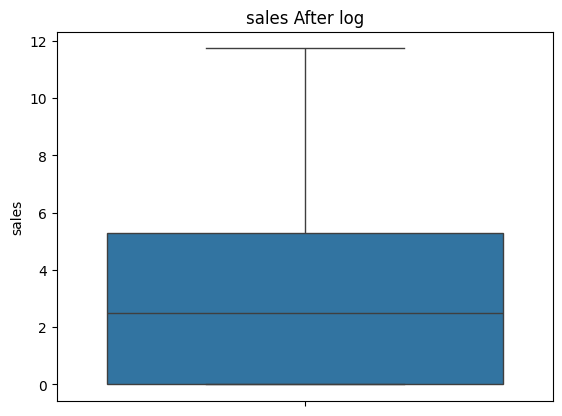

In [43]:
plt.title("sales After log")
sns.boxplot(train["sales"])

<Axes: title={'center': 'sales After log'}, xlabel='sales', ylabel='Count'>

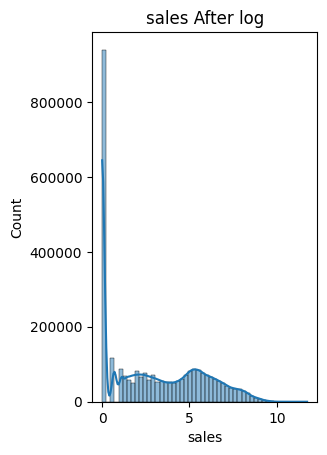

In [44]:
plt.subplot(1,2,2)
plt.title("sales After log")
sns.histplot(train["sales"], bins=50, kde=True)

<Axes: title={'center': 'onpromotion before log'}, xlabel='onpromotion', ylabel='Count'>

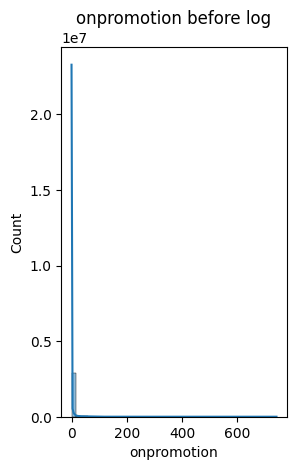

In [45]:
plt.subplot(1,2,2)
plt.title("onpromotion before log")
sns.histplot(train["onpromotion"], bins=50, kde=True)

<Axes: title={'center': 'onpromotion before log'}, ylabel='onpromotion'>

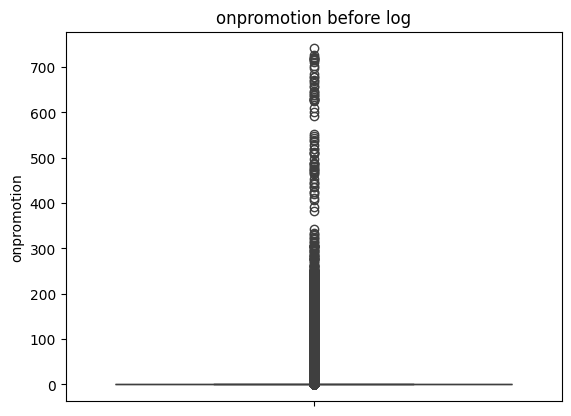

In [46]:
plt.title("onpromotion before log")
sns.boxplot(train["onpromotion"])

## Handling onpromotion outliers

In [47]:
train["onpromotion"]=np.log1p(train["onpromotion"])

<Axes: title={'center': 'onpromotion After log'}, xlabel='onpromotion', ylabel='Count'>

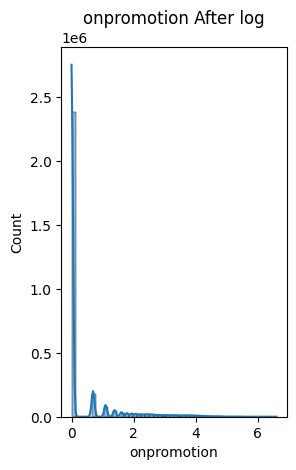

In [48]:
plt.subplot(1,2,2)
plt.title("onpromotion After log")
sns.histplot(train["onpromotion"], bins=50, kde=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x1a1cf5acf50>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1cf5ad1d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a1cf5ace10>],
 'medians': [<matplotlib.lines.Line2D at 0x1a1cf5ad450>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a1cf5ad590>],
 'means': []}

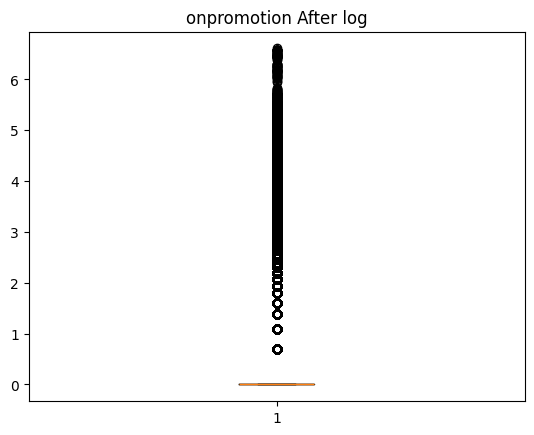

In [49]:
plt.title("onpromotion After log")
plt.boxplot(train["onpromotion"])

## Add Feature Engineering

To enhance our dataset with time-related insights, we extract several features from the `date` column.  
This helps capture seasonal patterns, monthly trends, and weekday effects in sales forecasting.

In [50]:
train["Year"]=pd.to_datetime(train["date"]).dt.year
train["Month"]=pd.to_datetime(train["date"]).dt.month
train["Day"]=pd.to_datetime(train["date"]).dt.day
train["Week_day"]=train["date"].dt.strftime("%A")

In [51]:
test["Year"]=pd.to_datetime(test["date"]).dt.year
test["Month"]=pd.to_datetime(test["date"]).dt.month
test["Day"]=pd.to_datetime(test["date"]).dt.day
test["Week_day"]=test["date"].dt.strftime("%A")

# 📊 Insights from Sales by Day Type

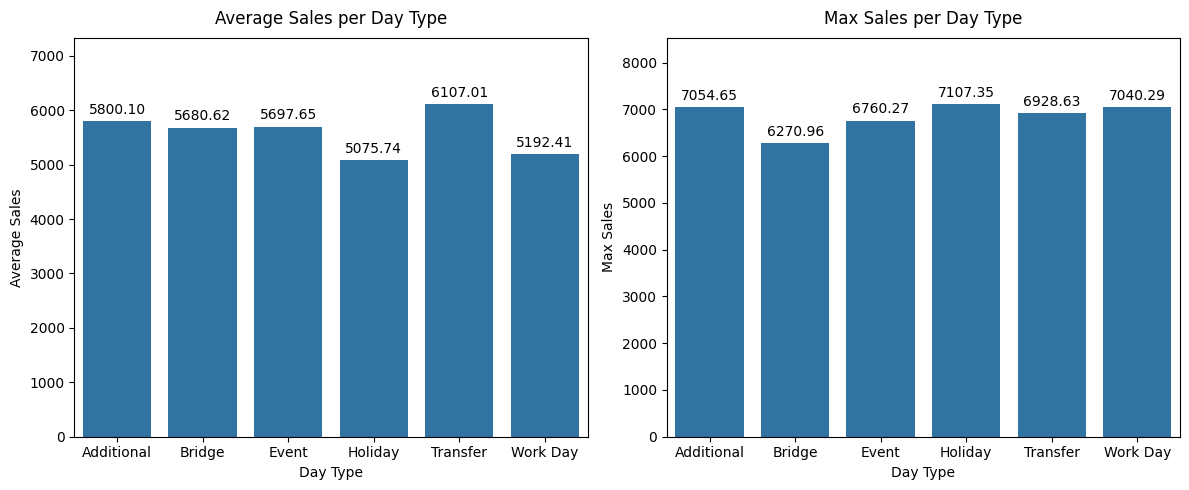

In [52]:
df = train.groupby(['date', 'day_type'])['sales'].sum().reset_index()
df = df.groupby('day_type').agg(mean_sales=('sales','mean'), max_sales=('sales','max')).reset_index()
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x='day_type', y='mean_sales', data=df, ax=axes[0])
axes[0].set_title("Average Sales per Day Type", pad=10)
axes[0].set_xlabel("Day Type")
axes[0].set_ylabel("Average Sales")
for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.2f", padding=3)
axes[0].set_ylim(0, df['mean_sales'].max() * 1.2)    

sns.barplot(x='day_type', y='max_sales', data=df, ax=axes[1])
axes[1].set_title("Max Sales per Day Type", pad=10)
axes[1].set_xlabel("Day Type")
axes[1].set_ylabel("Max Sales")
for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.2f", padding=3)
axes[1].set_ylim(0, df['max_sales'].max() * 1.2)     

plt.tight_layout()
plt.show()


## 🔹 Average Sales per Day Type
- **Highest Average Sales:** `Transfer` → ~6107  
- **Lowest Average Sales:** `Holiday` → ~5076  
- `Work Day` → ~5192 (also relatively low)  
- `Additional` (~5800) and `Event` (~5698) perform moderately.  
- `Bridge` (~5681) is slightly lower than Additional and Event.  

👉 **Insight:** Transfer days consistently drive higher average sales, while Holidays and Workdays drag the average down.

---

## 🔹 Max Sales per Day Type
- **Highest Max Sales:** `Holiday` → ~7107  
- Followed closely by `Work Day` (~7040) and `Additional` (~7055)  
- **Lowest Max Sales:** `Bridge` → ~6271  
- `Event` (~6760) and `Transfer` (~6929) fall in the middle range.  

👉 **Insight:** While Holidays show weak averages, they can still generate the **highest single-day peaks**, suggesting occasional spikes in customer demand.

---

## 📝 Conclusion
- **Transfer days** → Most reliable for **average sales**.  
- **Holidays** → Low average but **highest peaks** → strong demand spikes possible.  
- **Work Days** → Moderate averages, **strong maximum potential**.  
- **Bridge days** → Weak across both metrics.  

✅ **Business Takeaway:**  
- Maximize promotions & inventory on **Transfer days** (steady demand).  
- Prepare for **spikes on Holidays** despite weak averages.  
- Optimize strategies for **Work Days** to leverage high peak sales.  
- Reconsider heavy investment in **Bridge days** as they add the least value. 

---
---



# 🏬 Insights from Sales by Store Type

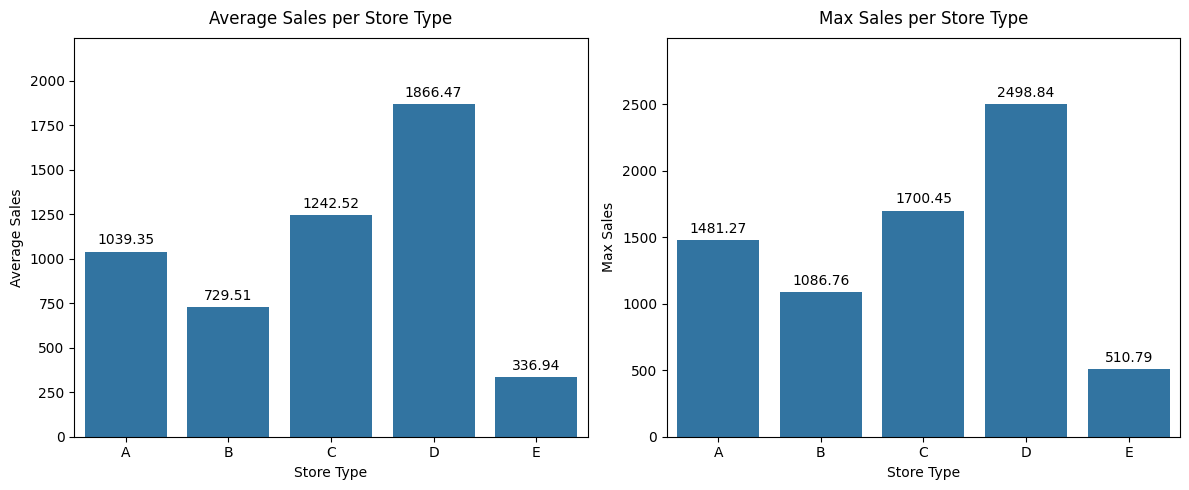

In [53]:
df = train.groupby(['date', 'store_type'])['sales'].sum().reset_index()

df = df.groupby('store_type').agg(mean_sales=('sales','mean'), max_sales=('sales','max')).reset_index()
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x='store_type', y='mean_sales', data=df, ax=axes[0])
axes[0].set_title("Average Sales per Store Type", pad=10)
axes[0].set_xlabel("Store Type")
axes[0].set_ylabel("Average Sales")
for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.2f", padding=3)
axes[0].set_ylim(0, df['mean_sales'].max() * 1.2)    

sns.barplot(x='store_type', y='max_sales', data=df, ax=axes[1])
axes[1].set_title("Max Sales per Store Type", pad=10)
axes[1].set_xlabel("Store Type")
axes[1].set_ylabel("Max Sales")
for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.2f", padding=3)
axes[1].set_ylim(0, df['max_sales'].max() * 1.2)     

plt.tight_layout()
plt.show()


## 🔹 Average Sales per Store Type
- **Highest Average Sales:** `Store Type D` → ~1866  
- **Lowest Average Sales:** `Store Type E` → ~337  
- `Store Type C` → ~1242 (strong performance)  
- `Store Type A` → ~1039 (moderate)  
- `Store Type B` → ~729 (lower side)  

👉 **Insight:** Store D significantly outperforms all others in average sales, while Store E trails far behind.

---

## 🔹 Max Sales per Store Type
- **Highest Max Sales:** `Store Type D` → ~2499  
- **Lowest Max Sales:** `Store Type E` → ~511  
- `Store Type C` → ~1700 (second best)  
- `Store Type A` → ~1481  
- `Store Type B` → ~1087  

👉 **Insight:** Store D also dominates in peak sales, reinforcing its overall performance. Store E continues to underperform in both average and peak metrics.

---

## 📝 Conclusion
- **Store Type D** → Clear top performer in both average and max sales.  
- **Store Type C** → Strong and consistent across both metrics.  
- **Store Type A** → Stable but not outstanding.  
- **Store Type B** → Needs improvement; underperforming.  
- **Store Type E** → Weakest across the board; strategy reevaluation needed.  

✅ **Business Takeaway:**  
- **Invest more in Store D** — expand, replicate its model, or prioritize inventory and marketing.  
- **Monitor Store C** for continued growth potential.
- **Optimize Store A** where possible, though it performs moderately well.  
- **Audit Stores B and E** to identify causes of underperformance.  
- **Store E** might require a strategic pivot or even closure if performance doesn't improve.

---
---


# 🏬 Store Sales Analysis (2013–2017)

In [54]:
df = train.groupby(['Year', 'store_type']).agg(sales=('sales', 'sum')).unstack()
df

sales                                               \
store_type              A              B              C              D   
Year                                                                     
2013        294833.072711  176513.214218  347167.041686  509858.051371   
2014        365588.471356  222241.954250  426688.057377  632180.062624   
2015        383242.398777  285070.811196  458298.658589  701623.280398   
2016        421745.092366  327168.448079  525643.244744  792230.082628   
2017        284855.868634  217492.773071  334600.760263  507251.827326   

                           
store_type              E  
Year                       
2013         70854.930586  
2014        100214.482854  
2015        137365.178708  
2016        156596.525545  
2017        102376.928043

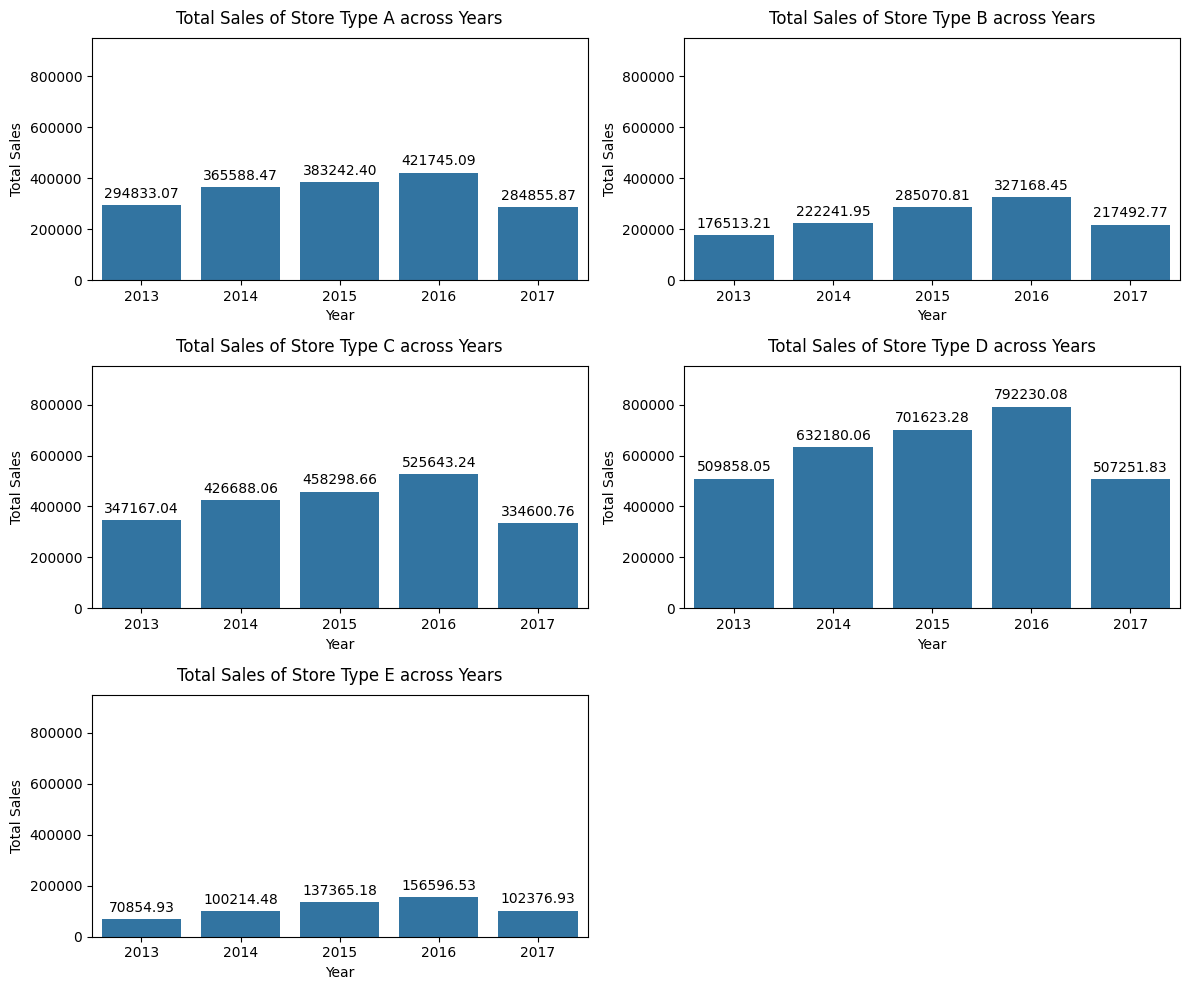

In [55]:
df = train.groupby(['Year', 'store_type'])['sales'].sum().reset_index()

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

temp_list = df['store_type'].unique().tolist()

for idx, store in enumerate(temp_list):
    temp = df[df['store_type'] == store]
    
    sns.barplot(x='Year', y='sales', data=temp, ax=axes[idx])
    
    axes[idx].set_title(f'Total Sales of Store Type {store} across Years', pad=10)
    axes[idx].set_xlabel('Year')
    axes[idx].set_ylabel('Total Sales')
    
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt="%.2f", padding=3)

    axes[idx].set_ylim(0, df['sales'].max() * 1.2)

for j in range(len(temp_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



## 🔢 Summary Table

| Store Type | Peak Year | Peak Sales ($) | Lowest Year | Lowest Sales ($) |
|------------|-----------|----------------|-------------|------------------|
| A | 2016 | 91.9M | 2013 | 47.0M |
| B | 2016 | 40.4M | 2013 | 18.5M |
| C | 2016 | 43.2M | 2013 | 23.5M |
| D | 2016 | 95.6M | 2013 | 45.8M |
| E | 2016 | 17.5M | 2013 | 5.7M |

---

## 📈 Key Trends

- **2013 → 2016**:  
  All store types show strong growth, with sales roughly **doubling or tripling**.  
- **2016**:  
  **Absolute peak year** across all store types (A–E).  
- **2017**:  
  Noticeable **decline in sales** for all store types compared to 2016.  

---

## 📉 Slump Pattern

- **2017 downturn** is consistent across all store categories.  
- Largest absolute drop: **Store D** (↓33M).  
- Smallest relative drop: **Store E** (still down but less dramatic).  

---

## 🧭 Strategic Insights

- **2016 was a boom year** — likely due to external drivers (market expansion, promotions, favorable economy).  
- **2017 decline** suggests possible **market saturation, economic slowdown, or stronger competition**.  
- Stores **A & D** dominate in total sales, but **E** shows fastest relative growth until 2016.  

---

## ✅ Conclusion

From **2013 to 2016**, the stores experienced a **strong growth trajectory**, culminating in record-high sales across all store types in 2016. However, the **sharp decline in 2017** across every store type signals a turning point. This pattern indicates that the surge in 2016 may have been **unsustainable**, possibly boosted by temporary factors, while 2017 reflects a **correction or external pressure**.  

👉 To maintain stability, businesses should:  
- Investigate the **2016 success drivers** (and replicate sustainable ones).  
- Analyze **2017 causes** (economic, competitive, or operational).  
- Diversify strategies to **avoid overdependence on short-term boosts**.  


---
---

# 📅 Monthly Sales Analysis (2013–2017)

In [56]:
df=train[['Year', 'Month', 'sales']]
df = df.groupby(['Year', 'Month'])['sales'].sum().unstack()
df['Total sales'] = df.sum(axis=1)
df['Max month'] = df.drop(columns=['Total sales']).idxmax(axis=1)
df['Max sales'] = df.drop(columns=['Total sales', 'Max month']).max(axis=1)
df['Min month'] = df.drop(columns=['Total sales', 'Max month', 'Max sales']).idxmin(axis=1)
df['Min sales'] = df.drop(columns=['Total sales', 'Max month', 'Max sales', 'Min month']).min(axis=1)
df.index.name='Year'
df.columns.name='Month'

df

Month,1,2,3,4,5,6,7,8,9,10,11,12,Total sales,Max month,Max sales,Min month,Min sales
Year,,,,,,,,,,,,,,,,,
2013,111260.072006,103894.446677,117382.861346,114120.948285,120336.620590,116810.290120,117808.654590,120072.351511,116150.546314,119119.144204,117858.177661,124412.197266,1.399226e+06,12,124412.197266,2,103894.446677
2014,158098.890982,111748.128553,164723.352853,118263.217616,121375.002036,119688.136113,164069.272704,125602.152888,162761.120128,167504.407362,162451.250343,170628.096882,1.746913e+06,12,170628.096882,2,111748.128553
2015,133564.762785,126257.970774,141775.826186,137442.309527,151572.389909,171799.411255,177938.193162,184090.791051,179634.691024,189576.570407,181841.551117,190105.860471,1.965600e+06,12,190105.860471,2,126257.970774
2016,183130.880757,176784.106978,187615.638949,185288.896882,191235.177207,181626.462207,189214.421910,186946.518651,178262.005718,185354.861576,182527.719521,195396.703004,2.223383e+06,12,195396.703004,2,176784.106978
2017,190366.770013,176450.075810,196250.374360,192167.841873,201464.902689,192699.707021,200173.553667,97004.931903,NaN,NaN,NaN,NaN,1.446578e+06,5,201464.902689,8,97004.931903


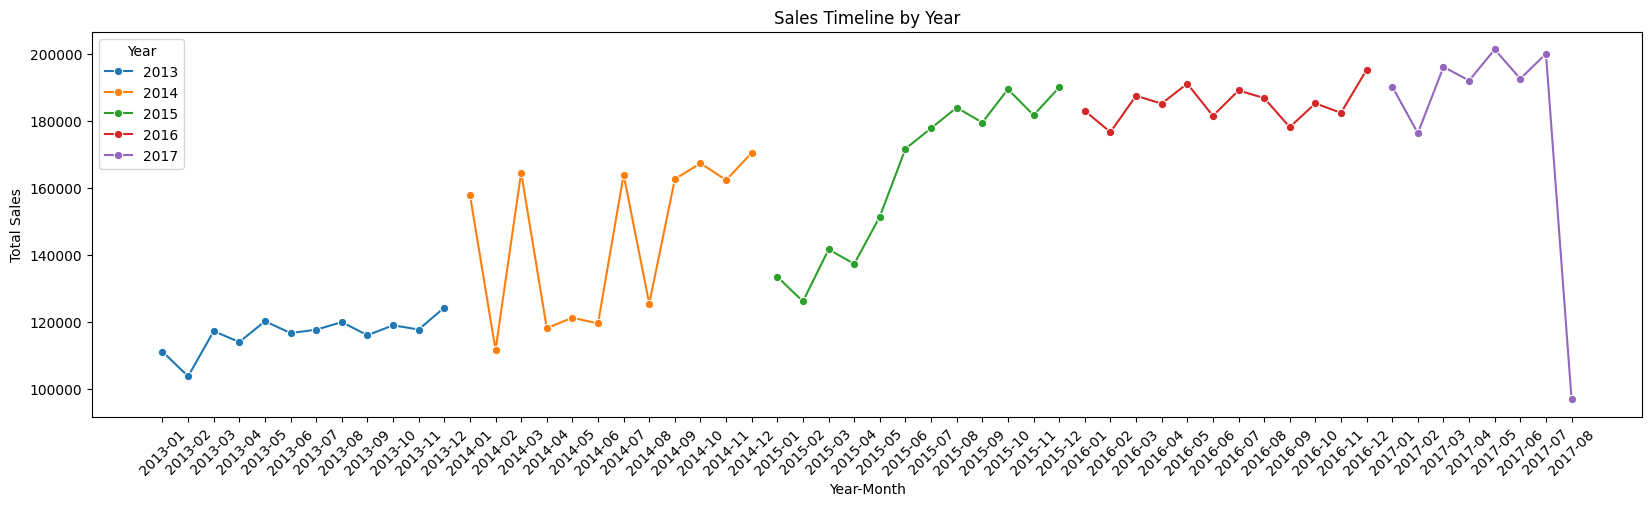

In [57]:
df = train.groupby(['Year', 'Month'])['sales'].sum().reset_index()

plt.figure(figsize=(20,5))


df['Year-Month'] = df['Year'].astype(str) + '-' + df['Month'].astype(str).str.zfill(2)

custom_palette = {
    2013: "#1f77b4",  
    2014: "#ff7f0e",  
    2015: "#2ca02c",  
    2016: "#d62728",  
    2017: "#9467bd"   
}

sns.lineplot(x='Year-Month', y='sales', hue='Year', data=df, marker="o", palette = custom_palette)

plt.xticks(rotation=45)   
plt.title("Sales Timeline by Year")
plt.xlabel("Year-Month")
plt.ylabel("Total Sales")
plt.legend(title="Year")
plt.show()



## 🔢 Summary Table

| Year | Total Sales | Max Month | Max Sales | Min Month | Min Sales |
|------|-------------|-----------|-----------|-----------|-----------|
| 2013 | 1.40M       | Dec       | 124,412   | Feb       | 103,894   |
| 2014 | 1.75M       | Dec       | 170,628   | Feb       | 111,748   |
| 2015 | 1.97M       | Dec       | 190,106   | Feb       | 126,258   |
| 2016 | 2.22M       | Dec       | 195,397   | Feb       | 176,784   |
| 2017 | 1.45M       | May       | 201,465   | Aug       | 97,005    |

---

## 📈 Key Trends

### 🔹 Growth from 2013–2016:
- **Consistent sales growth** year-over-year:
  - 2013 → 1.40M  
  - 2014 → 1.75M  
  - 2015 → 1.97M  
  - 2016 → 2.22M ✅ Peak year
- **December** was the **strongest month** every year (2013–2016), indicating strong **year-end demand** or seasonal shopping behavior.

### 🔹 Sudden drop in 2017:
- Despite a **very strong first half** (Jan–Jun all above 190K), total sales **plummeted** mid-year.
- **August 2017** marked the **lowest monthly sales** across all years: **~97K**.
- **Missing data** from September to December further drops the total to **1.45M**, much lower than expected.

---

## 📉 February Slump Pattern

| Year | Feb Sales | % Drop from Jan |
|------|-----------|-----------------|
| 2013 | 103,894   | -6.6%           |
| 2014 | 111,748   | -29.3%          |
| 2015 | 126,258   | -5.5%           |
| 2016 | 176,784   | -3.5%           |
| 2017 | 176,450   | -7.3%           |

- Every year, **February** is the **lowest or second-lowest month**.
- Suggests a **recurring seasonal dip** — likely post-holiday demand exhaustion.

---

## 🔍 Noteworthy Highlights

- 📈 **2017 May** had the **highest monthly sales ever recorded**: **201,465**.
- 🛑 But just **3 months later (Aug)**, sales **crashed to 97,005** — a **52% drop**.
- 📉 This drop ended a 4-year growth streak and **requires urgent investigation**.

---

## 🧠 Strategic Insights

### ✅ 2013–2016: Growth Phase
- Well-managed operations and demand generation.
- Strong December sales imply effective holiday promotions.

### ❌ 2017: Disruption Phase
- Despite record sales in May, missing data and August crash suggest:
  - Possible **operational failure** (e.g., inventory, logistics).
  - **External factors** (market downturn, policy shifts).
  - **Data reporting gaps** — Sep–Dec missing.

---

## ✅ Recommendations

- 📊 **Leverage Dec trend**: Plan major promotions, inventory, and campaigns for year-end.
- 📉 Prepare for Feb slowdowns: Use loyalty campaigns or bundled offers to stimulate demand.
- 🔍 **Investigate 2017 crash**:
  - Understand the **reason behind the drop after May**.
  - Validate whether **missing data** (Sep–Dec 2017) is due to:
    - Reporting error
    - Actual operational halt (e.g., store closures, tech issues)
- 🧪 Run sensitivity analysis: How would 2017 have performed if Sep–Dec data followed the Jan–Jun trend?

---
---


# 📊 Oil Price Timeline (2013–2017)

In [58]:
df = train[['Year', 'Month', 'dcoilwtico']]
df = df.groupby(['Year', 'Month'])['dcoilwtico'].mean().unstack()

df['Avg'] = df.mean(axis=1)
df['Max month'] = df.idxmax(axis=1)
df['Max price'] = df.drop(columns=['Max month']).max(axis=1)
df['Min month'] = df.drop(columns=['Max month', 'Max price']).idxmin(axis=1)
df['Min price'] = df.drop(columns=['Max month', 'Max price', 'Min month']).min(axis=1)
df.index.name='Year'
df.columns.name='Month'

df

Month,1,2,3,4,5,6,7,8,9,10,11,12,Avg,Max month,Max price,Min month,Min price
Year,,,,,,,,,,,,,,,,,
2013,94.632258,95.403571,93.217097,91.793000,94.654516,95.584333,104.776774,106.666452,106.491000,100.674839,93.892667,97.609333,97.949653,8,106.666452,4,91.793000
2014,94.594516,100.592143,100.972258,102.260667,102.244839,105.850667,103.687419,96.636774,93.409000,84.533226,75.630667,59.159667,93.297653,6,105.850667,12,59.159667
2015,47.862903,50.711786,47.761290,53.918000,59.320000,59.741000,51.413226,43.179355,45.438333,46.334194,42.221000,37.137667,48.753229,6,59.741000,12,37.137667
2016,32.244516,30.297241,37.684516,40.612000,46.837419,48.587333,44.922258,44.951613,44.952000,49.664516,45.511333,51.981000,43.187146,12,51.981000,2,30.297241
2017,52.698065,53.550357,49.309032,51.106667,48.515484,45.203000,46.536129,48.979333,NaN,NaN,NaN,NaN,49.487258,2,53.550357,6,45.203000


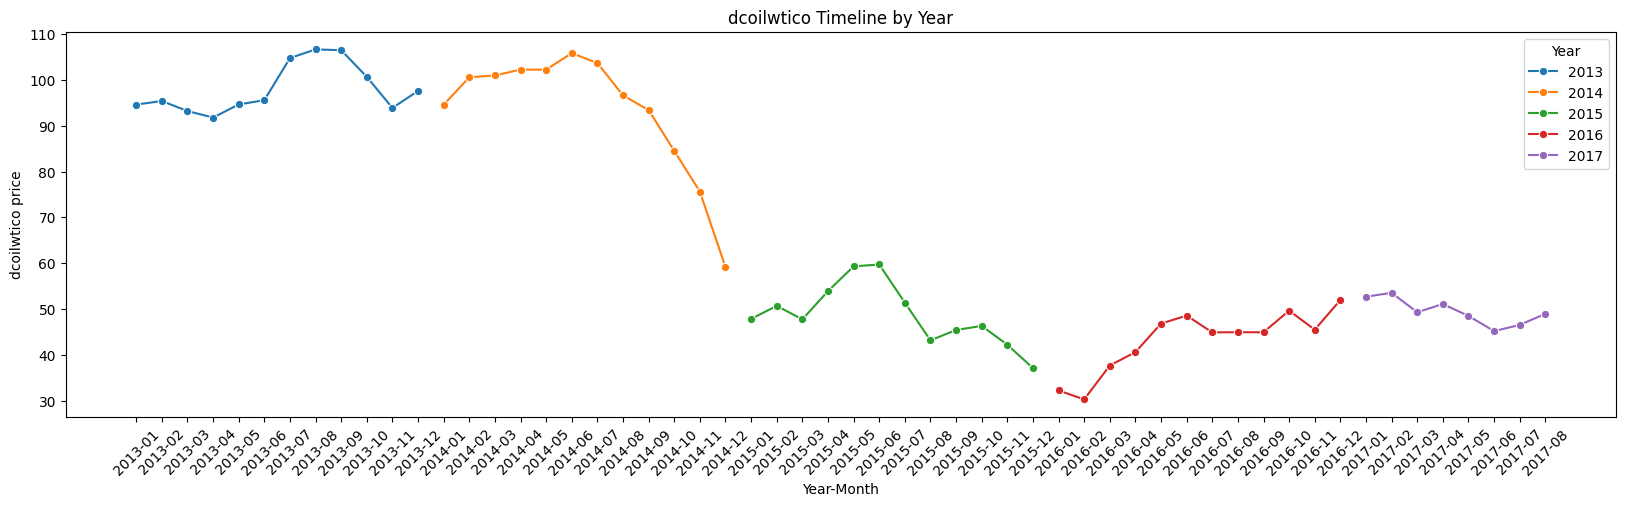

In [59]:
df = train.groupby(['Year', 'Month'])['dcoilwtico'].mean().reset_index()

plt.figure(figsize=(20,5))


df['Year-Month'] = df['Year'].astype(str) + '-' + df['Month'].astype(str).str.zfill(2)

custom_palette = {
    2013: "#1f77b4",  
    2014: "#ff7f0e",  
    2015: "#2ca02c",  
    2016: "#d62728",  
    2017: "#9467bd"   
}

sns.lineplot(x='Year-Month', y='dcoilwtico', hue='Year', data=df, marker="o", palette = custom_palette)

plt.xticks(rotation=45)
plt.title("dcoilwtico Timeline by Year")
plt.xlabel("Year-Month")
plt.ylabel("dcoilwtico price")
plt.legend(title="Year")
plt.show()


## 🔍 Insights
- *2013–2014:* Oil prices were relatively high, fluctuating between *$90–$110*, peaking in mid-2014.  
- *Late 2014:* A sharp *decline began*, dropping from above $100 to nearly $60 by the end of the year.  
- *2015:* Continued volatility, prices ranged from *$40–$60*, with some minor recovery attempts mid-year.  
- *2016:* Prices reached their *lowest point (~$30 in early 2016), then slowly recovered toward *$50**.  
- *2017:* Stabilization phase, prices hovered between *$45–$55*, showing less volatility than previous years.  

## ✅ Conclusion
The chart clearly shows that the oil market underwent a *major crisis starting in late 2014*, with prices collapsing from historical highs to record lows in early 2016.  
By 2017, prices had *stabilized at moderate levels*, signaling the end of extreme volatility but not a full return to pre-2014 highs.  
This reflects the impact of global supply-demand shifts, geopolitical factors, and production adjustments.

---

---

## Encoding

## Create df for encoding

In [60]:
df_encoding=train.copy()

## Add Column Work_day for Binary encoding

In [61]:
df_encoding["Work_day"] = [1 if x == "Work Day" else 0 for x in df_encoding["day_type"]]

### Encoding for Categorial Columns with One-Hot-Encoding

In [62]:
n=["sales","onpromotion","dcoilwtico"]
c=["Week_day","family","city","state","day_type"]
df_encoding=pd.get_dummies(data=df_encoding,columns=c,drop_first=True)

## Encoding store_type Column

In [63]:
lb=LabelEncoder()
df_encoding["store_type_encoded"]=lb.fit_transform(df_encoding["store_type"])

In [64]:
df_encoding.drop(["date","store_type","day_type_Work Day"],axis=1,inplace=True)

# Scaling For Quantative Data

In [65]:
sc=StandardScaler()
df_encoding[n]=sc.fit_transform(df_encoding[n])

<Axes: >

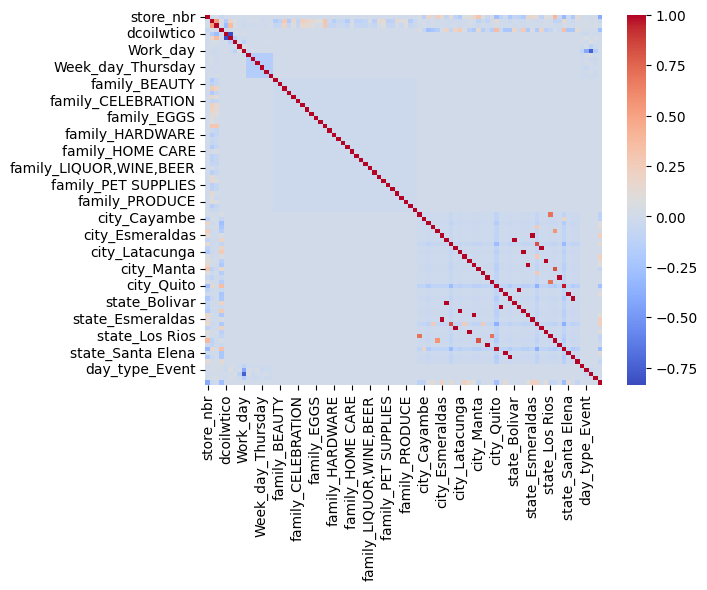

In [66]:
sns.heatmap(df_encoding.corr(),cmap="coolwarm")

## Encoding Test

## Create df for encoding

In [67]:
test_encoding=test.copy()

## Add Column Work_day for Binary encoding

In [68]:
test_encoding["Work_day"] = [1 if x == "Work Day" else 0 for x in test_encoding["day_type"]]

### Encoding for Categorial Columns with One-Hot-Encoding

In [69]:
n=["onpromotion","dcoilwtico"]
c=["Week_day","family","city","state","day_type"]
test_encoding=pd.get_dummies(data=test_encoding,columns=c,drop_first=True)

## Encoding store_type Column

In [70]:
lb=LabelEncoder()
test_encoding["store_type_encoded"]=lb.fit_transform(test_encoding["store_type"])

In [71]:
test_encoding.drop(["date","store_type","day_type_Work Day"],axis=1,inplace=True)

<Axes: >

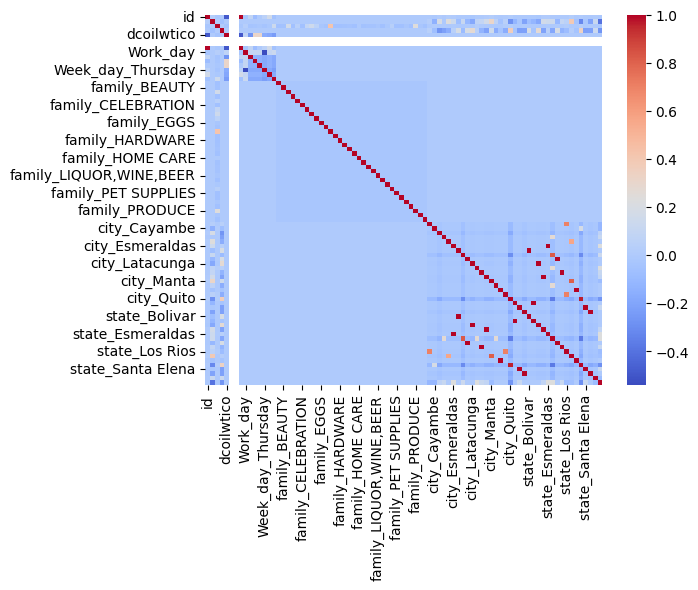

In [72]:
sns.heatmap(test_encoding.corr(),cmap="coolwarm")

### Add missing columns in `test` compared to `train`

In [73]:
for i in df_encoding.columns:
    if i not in test_encoding.columns and i!="sales":
        test_encoding[i]=[0]*test_encoding.shape[0]
        

### Check len Columns

In [74]:
print(len(df_encoding.columns))
print(len(test_encoding.columns))

88
88


## Import DataFrames into Csv Files

In [75]:
# train.to_csv("train_cleaned.csv",index=False)
# df_encoding.to_csv("train_encoded.csv",index=False)
# test_encoding.to_csv("test_encoded.csv",index=False)